### Unidade Chácara — Análise Socioeconômica e Populacional

Esta análise utiliza dados censitários do **IBGE (Censo 2022)** em um raio de **5 km** ao redor da **Unidade Chácara – Colégio Elvira Brandão**.  
O objetivo é compreender o perfil **socioeconômico e demográfico** da região, servindo de base para **estratégias de marketing e captação de alunos**.  

Os dados foram obtidos a partir de fontes oficiais do IBGE:  
- [Censo IBGE 2022 — Dados Demográficos](https://censo2022.ibge.gov.br/)  
- [API IBGE — Indicadores Sociais e Econômicos](https://servicodados.ibge.gov.br/api/docs/)

## Bibliotecas e Análise Exploratória das Colunas e Bairros da Região

In [18]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from branca.element import MacroElement
from jinja2 import Template
import html
import os
from IPython.display import IFrame, display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Carregar CSV
df = pd.read_csv('Elvira - Chacara - INEP 35107700 Dados ADS_coords_corrigidas_com_enderecos.csv')

In [19]:
# Verificar as colunas disponíveis
print("Colunas disponíveis no DataFrame:")
print(df.columns.tolist())

Colunas disponíveis no DataFrame:
['id', 'ano', 'latitude_centro', 'longitude_centro', 'radius', 'distance_unit', 'populacao_total', 'renda_media', 'v01031_0_4anos', 'v01032_5_9anos', 'v01033_10_14anos', 'v01034_15_19anos', 'Total', 'CEP', 'Bairro', 'Cidade', 'UF', 'Logradouro']


In [20]:
# Mostrar todos os bairros únicos
print("Bairros disponíveis:")
print(df['Bairro'].unique())

Bairros disponíveis:
['Brooklin Velho' 'Campo Belo' 'Jabaquara' 'Campo Grande'
 'Jardim Marajoara' 'Jardim Santo Amaro' nan 'Jardim Maria Duarte'
 'Campo Limpo' 'Vila Andrade' 'Capão Redondo' 'Cidade Ademar'
 'Vila Olímpia' 'Brooklin Novo' 'Itaim Bibi' 'Jardim Petrópolis'
 'Jardim São Luís' 'Cidade Jardim' 'Morumbi' 'Vila Sônia' 'Santo Amaro'
 'Granja Julieta' 'Chácara Flora' 'Chácara Santo Antônio'
 'Chácara Monte Alegre' 'Jardim dos Estados' 'Socorro' 'Paraisópolis'
 'Ferreira']


## 1. Distribuição Geográfica dos Dados

In [21]:
# Dados do colégio (coordenadas confirmadas)
escola_nome = 'Unidade Chácara - Elvira Brandão'
escola_endereco = 'R. Paulo Assunção, 97 - Chácara Santo Antônio, São Paulo - SP, 04729-080'
escola_lat = -23.6336779
escola_lon = -46.7132727

# Salário mínimo (usa valor existente ou padrão)
salario_minimo = globals().get('salario_minimo', 1380.0)

# Garante que df esteja carregado e normaliza renda_media
if 'df' not in globals():
    raise RuntimeError('DataFrame `df` não está carregado. Rode a célula de leitura do CSV antes.')
if 'renda_media' in df.columns:
    df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False).str.replace(r'\s+', '', regex=True)
    df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
else:
    df['renda_media'] = pd.NA
df['renda_sm'] = df['renda_media'] / salario_minimo

# Formatação BRL para popups
def fmt_brl(x):
    try:
        if x is None or (isinstance(x, float) and np.isnan(x)):
            return 'Sem dado'
        v = float(x)
        s = f"{v:,.2f}"
        s = s.replace(',','X').replace('.',',').replace('X','.')
        return f"R$ {s}"
    except Exception:
        return str(x)

# Cores sólidas solicitadas pelo usuário
CORES_SM = {
    '≤1': "#2f7eed",    # Azul claro
    '1-2': '#ffffb3',   # Amarelo claro
    '2-5': '#fdbf00',   # Amarelo escuro
    '5-10': '#ff7f0e',  # Laranja
    '>10': '#d62728',   # Vermelho
    'Sem dado': '#7f7f7f',
}

def faixa_cor_label(r_sm):
    if pd.isna(r_sm):
        return (CORES_SM['Sem dado'], 'Sem dado')
    if r_sm <= 1:
        return (CORES_SM['≤1'], '≤ 1 SM')
    if r_sm <= 2:
        return (CORES_SM['1-2'], '1-2 SM')
    if r_sm <= 5:
        return (CORES_SM['2-5'], '2-5 SM')
    if r_sm <= 10:
        return (CORES_SM['5-10'], '5-10 SM')
    return (CORES_SM['>10'], '> 10 SM')

# Calcula contagens por faixa para legendas
total = len(df)
bins = [(-np.inf,1,'≤1'), (1,2,'1-2'), (2,5,'2-5'), (5,10,'5-10'), (10,np.inf,'>10')]
counts = {}
for lo, hi, key in bins:
    if lo == -np.inf:
        mask = df['renda_sm'] <= hi
    elif hi == np.inf:
        mask = df['renda_sm'] > lo
    else:
        mask = (df['renda_sm'] > lo) & (df['renda_sm'] <= hi)
    cnt = int(mask.sum()) if total>0 else 0
    pct = (cnt/total*100) if total>0 else 0
    counts[key] = {'count': cnt, 'pct': pct}

# Centro do mapa: prefere map_center/lat/lon, senão coordenadas do colégio
if 'map_center' in globals() and isinstance(map_center, (list, tuple)) and len(map_center) >= 2:
    centro = map_center[:2]
elif 'lat' in globals() and 'lon' in globals():
    centro = [lat, lon]
else:
    centro = [escola_lat, escola_lon]

m = folium.Map(location=centro, zoom_start=13, tiles='OpenStreetMap')

# Adiciona marcadores com cor sólida e contagem no popup
for _, row in df.iterrows():
    try:
        if 'latitude_centro' in df.columns and 'longitude_centro' in df.columns:
            lat_row = row.get('latitude_centro')
            lon_row = row.get('longitude_centro')
        elif 'latitude' in df.columns and 'longitude' in df.columns:
            lat_row = row.get('latitude')
            lon_row = row.get('longitude')
        else:
            lat_row = row.get('lat') or row.get('LAT') or row.get('Latitude')
            lon_row = row.get('lon') or row.get('LON') or row.get('Longitude')
        if pd.isna(lat_row) or pd.isna(lon_row):
            continue
        latf = float(lat_row)
        lonf = float(lon_row)
        color, label = faixa_cor_label(row.get('renda_sm', np.nan))
        renda_form = fmt_brl(row.get('renda_media'))
        renda_sm_val = row.get('renda_sm', np.nan)
        renda_sm_str = f"{renda_sm_val:.2f}" if not pd.isna(renda_sm_val) else 'Sem dado'
        popup_html = f"CEP: {html.escape(str(row.get('CEP','')))}<br>Bairro: {html.escape(str(row.get('Bairro','')))}<br>Rua: {html.escape(str(row.get('Logradouro','')))}<br>Renda média: {renda_form}<br>Renda (SM): {renda_sm_str}"
        folium.CircleMarker(location=[latf, lonf], radius=6, color='black', weight=0.5, fill=True, fill_color=color, fill_opacity=0.95, popup=folium.Popup(popup_html, max_width=300)).add_to(m)
    except Exception:
        continue

# Marcador do colégio com coordenadas exatas e popup correto
folium.Marker(location=[escola_lat, escola_lon], popup=folium.Popup(f"<b>{escola_nome}</b><br>{escola_endereco}", max_width=350), icon=folium.Icon(color='purple', icon='star')).add_to(m)

# Cria HTML da legenda com contagens e cores
legend_items = [
    (CORES_SM['≤1'], f"≤ 1 SM — {counts['≤1']['count']} CEPs ({counts['≤1']['pct']:.1f}%) — Até {fmt_brl(salario_minimo)}"),
    (CORES_SM['1-2'], f"1-2 SM — {counts['1-2']['count']} CEPs ({counts['1-2']['pct']:.1f}%) — {fmt_brl(salario_minimo*2)}"),
    (CORES_SM['2-5'], f"2-5 SM — {counts['2-5']['count']} CEPs ({counts['2-5']['pct']:.1f}%)"),
    (CORES_SM['5-10'], f"5-10 SM — {counts['5-10']['count']} CEPs ({counts['5-10']['pct']:.1f}%)"),
    (CORES_SM['>10'], f"> 10 SM — {counts['>10']['count']} CEPs ({counts['>10']['pct']:.1f}%)"),
]

legend_html = """{% macro html(this, kwargs) %}\n<div style=\"position: fixed; bottom: 50px; left: 50px; width: 340px; z-index:9999; font-size:13px;\">\n  <div style=\"background:white; padding:10px; border:2px solid grey;\">\n    <b>Faixas (SM)</b><br>\n    __ITEMS__\n  </div>\n</div>\n{% endmacro %}\n"""
items_html = ''.join([f"<div style=\"margin-top:6px;\"><span style=\"display:inline-block;width:16px;height:10px;background:{c};margin-right:6px;\"></span> {txt}</div>" for c, txt in legend_items])
legend_html = legend_html.replace('__ITEMS__', items_html)
macro = MacroElement()
macro._template = Template(legend_html)
m.get_root().add_child(macro)

# Salva o mapa atualizado
m.save('mapa_interativo_chacara.html')
print('Mapa salvo em mapa_interativo_chacara.html — centro:', centro)

Mapa salvo em mapa_interativo_chacara.html — centro: [-23.6336779, -46.7132727]


In [22]:
# Exibir o mapa interativo salvo em 'mapa_interativo_chacara.html'
# Prioriza exibir o objeto folium 'm' se ele existir no kernel, senão usa IFrame,
# e como fallback tenta abrir no navegador padrão.
try:
    display(m)
except Exception:
    pass
map_path = 'mapa_interativo_chacara.html'
if os.path.exists(map_path):
    try:
        display(IFrame(map_path, width=900, height=600))
    except Exception:
        import webbrowser
        webbrowser.open(os.path.abspath(map_path))
else:
    print(f'Arquivo {map_path} não encontrado. Rode a célula que gera o mapa primeiro.')

# 2. Análise de Correlação entre Variáveis

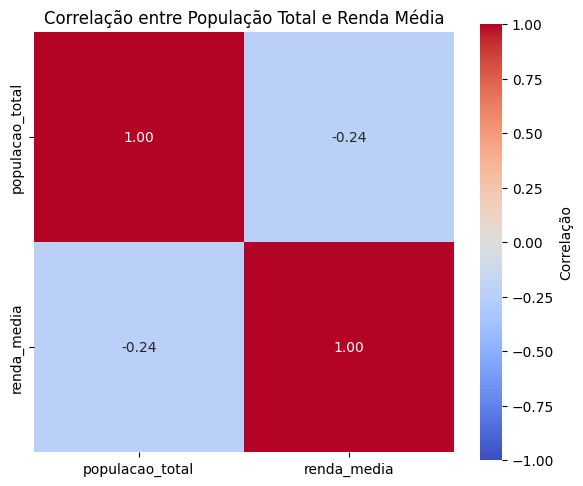

Correlação de Pearson: -0.240
Amostras analisadas: 1744


In [23]:
# Correlação entre população e renda média

# Carregar CSV (opcional — primeira célula já carrega `df`)
if 'df' not in globals():
    df = pd.read_csv('Elvira - Chacara - INEP 35107700 Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter colunas numéricas
if 'renda_media' in df.columns:
    df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
    df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
else:
    df['renda_media'] = pd.NA

if 'populacao_total' in df.columns:
    df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

corr_data = df[['populacao_total', 'renda_media']].dropna()
plt.figure(figsize=(6, 5))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlação'})
plt.title('Correlação entre População Total e Renda Média')
plt.tight_layout()
plt.show()

# Calcular e exibir correlação de Pearson
pearson_corr = corr_data['populacao_total'].corr(corr_data['renda_media'])
print(f'Correlação de Pearson: {pearson_corr:.3f}')
print(f'Amostras analisadas: {len(corr_data)}')

In [24]:
# Mostrar estatísticas descritivas (usa `df` carregado na célula inicial)
if 'df' not in globals():
    df = pd.read_csv('Elvira - Chacara - INEP 35107700 Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter colunas numéricas
if 'renda_media' in df.columns:
    df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
    df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

if 'populacao_total' in df.columns:
    df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Mostrar estatísticas descritivas
print("\nEstatísticas:")
print(f"Número de CEPs analisados: {len(df)}")
print(f"População total: {df['populacao_total'].sum():,}")
print(f"Renda média: R$ {df['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df['renda_media'].max():,.2f}")


Estatísticas:
Número de CEPs analisados: 1758
População total: 702,950
Renda média: R$ 9,496.82
Renda média mínima: R$ 1,154.58
Renda média máxima: R$ 73,198.95


<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
A análise geral considera <b>1.758 amostras</b>, abrangendo uma população total de aproximadamente <b>702.950 habitantes</b> e 
renda média de <b>R$ 9.496,82</b>. Os valores variam entre <b>R$ 1.154,58</b> e <b>R$ 73.198,95</b>, refletindo uma ampla 
<b>disparidade socioeconômica</b> entre as regiões analisadas.
<br><br>
O coeficiente de <b>correlação de Pearson (-0,24)</b> indica uma relação negativa fraca entre <b>população</b> e <b>renda média</b>. 
Isso sugere que áreas mais densamente povoadas tendem a apresentar rendas menores, enquanto regiões menos populosas concentram 
níveis mais altos de renda média.
<br><br>
Esse padrão reflete a estrutura urbana típica de grandes centros metropolitanos, onde a <b>distribuição de renda é heterogênea</b> 
e a concentração populacional tende a se associar a zonas de menor renda. Essas diferenças socioeconômicas foram consideradas 
para compreender o <b>perfil das áreas de captação</b> e mapear a <b>relação entre densidade populacional e poder aquisitivo</b> 
ao redor da Escola Elvira Brandão, oferecendo uma base mais precisa para <b>análises estratégicas de expansão e posicionamento</b>.

</div>

# Correlação entre População Total e Renda Média
Chácara Santo Antônio, Granja Julieta e Santo Amaro

## Chácara Santo Antônio

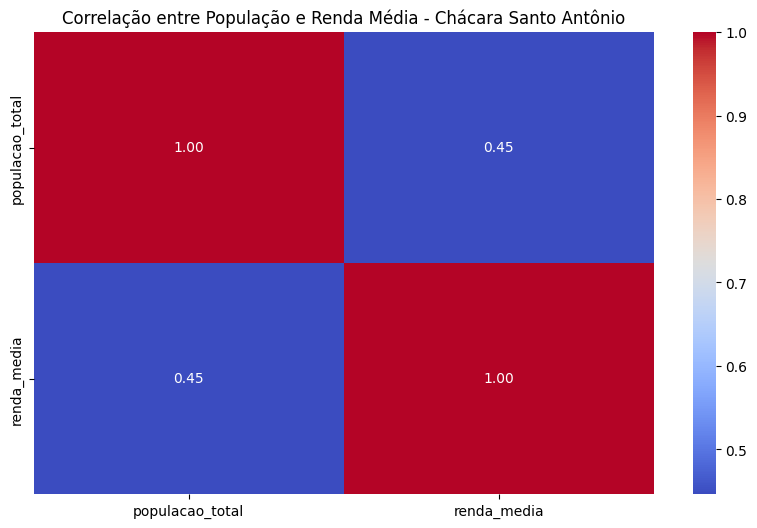


Estatísticas do bairro Chácara Santo Antônio:
Número de CEPs analisados: 43
População total do bairro: 13,599
Renda média do bairro: R$ 11,505.43
Renda média mínima: R$ 3,649.84
Renda média máxima: R$ 33,056.51


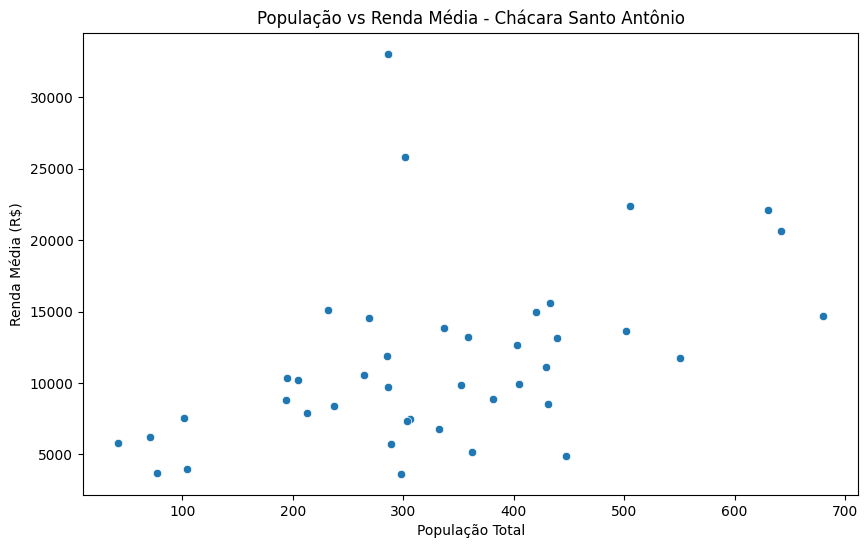

In [25]:
# Converter colunas numéricas (robusta, suporta vírgula decimal)
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Filtrar apenas dados da Chácara Santo Antônio
df_chacara = df[df['Bairro'] == 'Chácara Santo Antônio']

# Análise de correlação entre população e renda média para Chácara Santo Antônio
plt.figure(figsize=(10, 6))
sns.heatmap(df_chacara[['populacao_total', 'renda_media']].corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')

# Exibir gráfico
plt.title('Correlação entre População e Renda Média - Chácara Santo Antônio')
plt.show()

# Mostrar estatísticas descritivas do bairro
print("\nEstatísticas do bairro Chácara Santo Antônio:")
print(f"Número de CEPs analisados: {len(df_chacara)}")
print(f"População total do bairro: {df_chacara['populacao_total'].sum():,}")
print(f"Renda média do bairro: R$ {df_chacara['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df_chacara['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df_chacara['renda_media'].max():,.2f}")

# Adicionar gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_chacara, x='populacao_total', y='renda_media')
plt.title('População vs Renda Média - Chácara Santo Antônio')
plt.xlabel('População Total')
plt.ylabel('Renda Média (R$)')
plt.show()

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O bairro <b>Chácara Santo Antônio</b> apresenta <b>renda média de R$ 11.505,43</b> e <b>população total de cerca de 13.599 habitantes</b>. 
A <b>correlação de 0,45</b> indica uma relação positiva moderada entre população e renda média, 
sugerindo que áreas mais populosas tendem a concentrar famílias com maior poder aquisitivo. 
O gráfico de dispersão mostra uma <b>distribuição ampla</b> de valores, com presença de faixas de renda elevadas e homogêneas. 
O bairro possui <b>perfil socioeconômico consolidado</b>, típico de regiões urbanas de classe média e alta, 
o que reforça seu potencial estratégico na <b>captação de alunos</b>.

</div>

## Granja Julieta

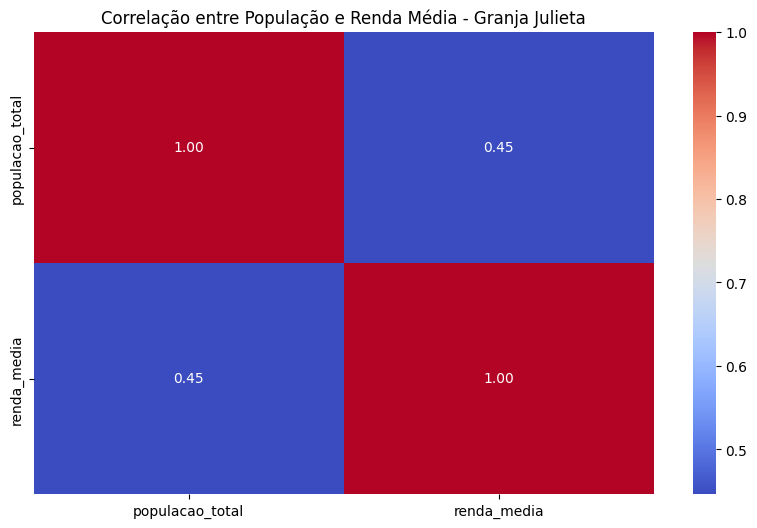


Estatísticas do bairro Granja Julieta:
Número de CEPs analisados: 44
População total do bairro: 18,870
Renda média do bairro: R$ 11,407.57
Renda média mínima: R$ 3,458.88
Renda média máxima: R$ 39,839.35


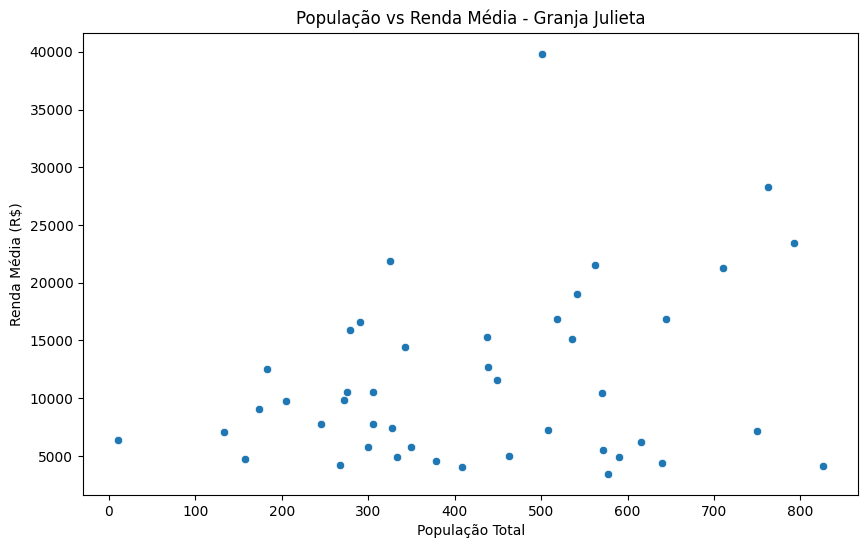

In [26]:
# Converter colunas numéricas (robusta, suporta vírgula decimal)
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Filtrar apenas dados da Granja Julieta
df_granja_julieta = df[df['Bairro'] == 'Granja Julieta']

# Análise de correlação entre população e renda média para Granja Julieta
plt.figure(figsize=(10, 6))
sns.heatmap(df_chacara[['populacao_total', 'renda_media']].corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')

# Exibir gráfico
plt.title('Correlação entre População e Renda Média - Granja Julieta')
plt.show()

# Mostrar estatísticas descritivas do bairro
print("\nEstatísticas do bairro Granja Julieta:")
print(f"Número de CEPs analisados: {len(df_granja_julieta)}")
print(f"População total do bairro: {df_granja_julieta['populacao_total'].sum():,}")
print(f"Renda média do bairro: R$ {df_granja_julieta['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df_granja_julieta['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df_granja_julieta['renda_media'].max():,.2f}")

# Adicionar gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_granja_julieta, x='populacao_total', y='renda_media')
plt.title('População vs Renda Média - Granja Julieta')
plt.xlabel('População Total')
plt.ylabel('Renda Média (R$)')
plt.show()

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O bairro <b>Granja Julieta</b> apresenta <b>renda média de R$ 11.407,57</b> e <b>população total aproximada de 18.870 habitantes</b>. 
A <b>correlação de 0,45</b> indica uma relação positiva moderada entre população e renda média, 
sugerindo que áreas com maior concentração populacional também possuem níveis de renda mais altos. 
O gráfico de dispersão mostra uma <b>ampla variação interna</b> nos valores, refletindo a presença de diferentes perfis socioeconômicos. 
O bairro se destaca por seu <b>padrão de renda elevado</b> e por abrigar uma população de <b>classe média e alta</b>, 
caracterizando-o como uma <b>zona de forte potencial de captação</b> para o entorno da Escola Elvira Brandão.

</div>


## Santo Amaro

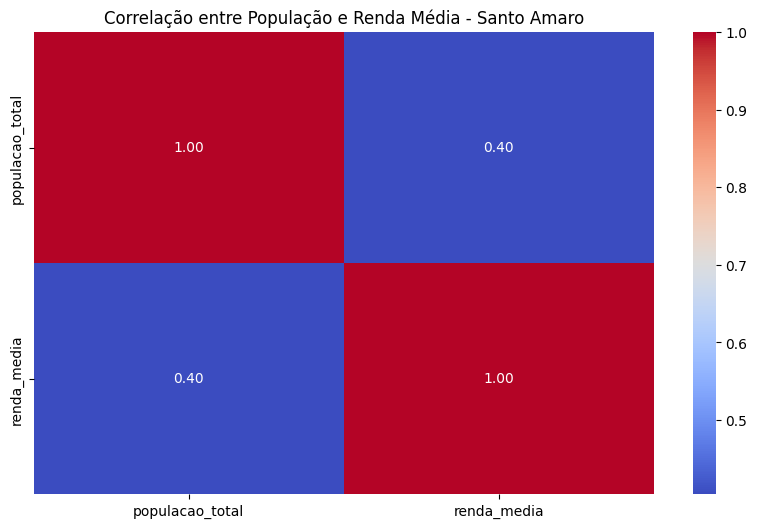


Estatísticas do bairro Santo Amaro:
Número de CEPs analisados: 60
População total do bairro: 23,097
Renda média do bairro: R$ 10,351.59
Renda média mínima: R$ 3,714.15
Renda média máxima: R$ 20,486.60


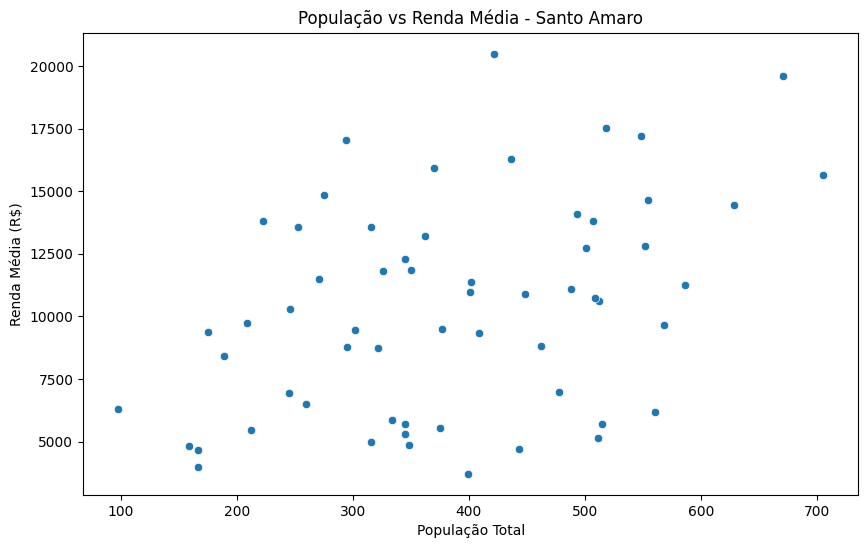

In [27]:
# Converter colunas numéricas (robusta, suporta vírgula decimal)
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce').fillna(0).astype(int)

# Filtrar apenas dados da Granja Julieta
df_santo_amaro = df[df['Bairro'] == 'Santo Amaro']

# Análise de correlação entre população e renda média para Santo Amaro
plt.figure(figsize=(10, 6))
sns.heatmap(df_santo_amaro[['populacao_total', 'renda_media']].corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')

# Exibir gráfico
plt.title('Correlação entre População e Renda Média - Santo Amaro')
plt.show()

# Mostrar estatísticas descritivas do bairro
print("\nEstatísticas do bairro Santo Amaro:")
print(f"Número de CEPs analisados: {len(df_santo_amaro)}")
print(f"População total do bairro: {df_santo_amaro['populacao_total'].sum():,}")
print(f"Renda média do bairro: R$ {df_santo_amaro['renda_media'].mean():,.2f}")
print(f"Renda média mínima: R$ {df_santo_amaro['renda_media'].min():,.2f}")
print(f"Renda média máxima: R$ {df_santo_amaro['renda_media'].max():,.2f}")

# Adicionar gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_santo_amaro, x='populacao_total', y='renda_media')
plt.title('População vs Renda Média - Santo Amaro')
plt.xlabel('População Total')
plt.ylabel('Renda Média (R$)')
plt.show()

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O bairro <b>Santo Amaro</b> apresenta <b>renda média de R$ 10.351,59</b> e <b>população total aproximada de 23.097 habitantes</b>. 
A <b>correlação de 0,40</b> indica uma relação positiva moderada entre população e renda média, 
sugerindo que áreas mais populosas tendem a manter níveis de renda relativamente altos. 
O gráfico de dispersão mostra uma <b>distribuição ampla de valores</b>, refletindo tanto segmentos de classe média quanto áreas com maior poder aquisitivo. 
O bairro apresenta um <b>perfil urbano diversificado</b> e consolidado, com potencial relevante para ações de <b>captação em diferentes faixas de renda</b>.

</div>


# 3. Distribuição de Renda (Salários Mínimos) — 10 Bairros Mais Próximos à Escola Elvira Brandão Morumbi

C:\Users\00157NLUC-BrenoR\AppData\Local\Temp\ipykernel_13464\443931787.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Bairro', y='renda_sm', data=df_proximos, order=top_bairros, palette='Set2')


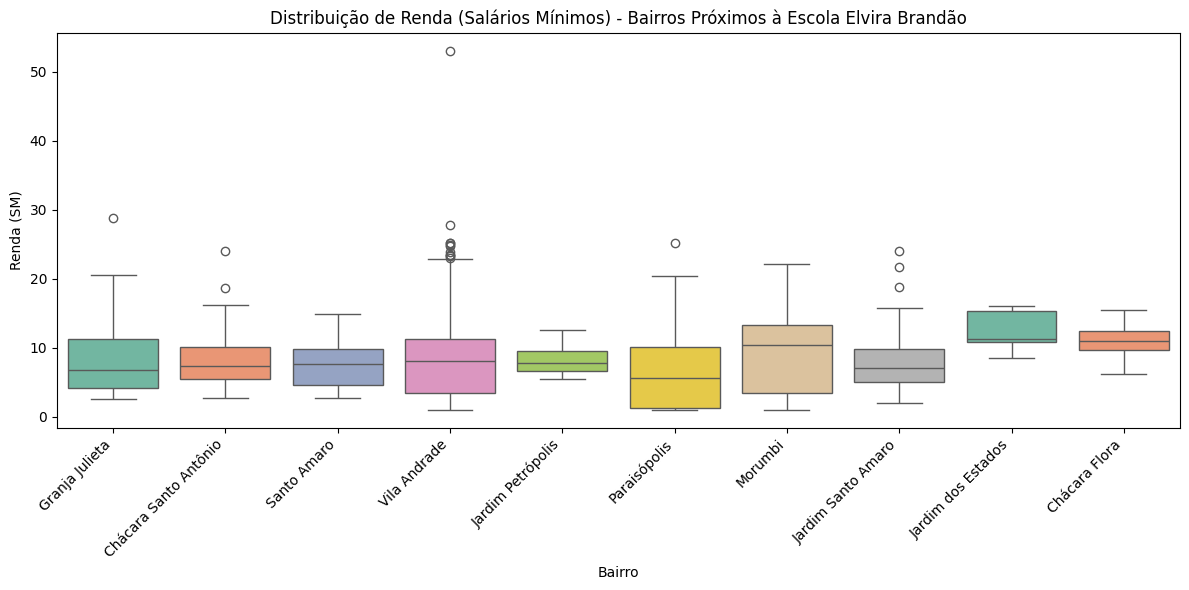


Bairros mais próximos da Escola Elvira Brandão:
1. Granja Julieta: Renda média = 8.27 SM (R$ 11,407.57)
2. Chácara Santo Antônio: Renda média = 8.34 SM (R$ 11,505.43)
3. Santo Amaro: Renda média = 7.50 SM (R$ 10,351.59)
4. Vila Andrade: Renda média = 8.80 SM (R$ 12,148.71)
5. Jardim Petrópolis: Renda média = 8.13 SM (R$ 11,217.81)
6. Paraisópolis: Renda média = 6.32 SM (R$ 8,728.06)
7. Morumbi: Renda média = 9.12 SM (R$ 12,580.25)
8. Jardim Santo Amaro: Renda média = 8.23 SM (R$ 11,354.24)
9. Jardim dos Estados: Renda média = 12.41 SM (R$ 17,123.85)
10. Chácara Flora: Renda média = 10.99 SM (R$ 15,159.43)


In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Carregar CSV com os dados
df = pd.read_csv('Elvira - Chacara - INEP 35107700 Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter renda_media: substituir vírgula por ponto
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

# Calcular renda em salários mínimos
salario_minimo = 1380.0
df['renda_sm'] = df['renda_media'] / salario_minimo

# Coordenadas da Escola Elvira Brandão
escola_lat = -23.6336779
escola_lon = -46.7132727

# Calcular distância de cada CEP até a escola (aproximação simples usando Pitagoras)
df['distancia'] = np.sqrt((df['latitude_centro'] - escola_lat)**2 + (df['longitude_centro'] - escola_lon)**2)

# Selecionar os 10 bairros mais próximos (agrupando por bairro e pegando a distância média)
bairro_dist = df.groupby('Bairro')['distancia'].mean().sort_values()
top_bairros = bairro_dist.head(10).index.tolist()

# Filtrar dados apenas dos bairros mais próximos
df_proximos = df[df['Bairro'].isin(top_bairros)].copy()

# Plotando a distribuição de renda em SM por bairro (ordenado por proximidade)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Bairro', y='renda_sm', data=df_proximos, order=top_bairros, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Distribuição de Renda (Salários Mínimos) - Bairros Próximos à Escola Elvira Brandão')
plt.ylabel('Renda (SM)')
plt.xlabel('Bairro')
plt.tight_layout()
plt.show()

# Estatísticas dos bairros mais próximos
print("\nBairros mais próximos da Escola Elvira Brandão:")
for i, bairro in enumerate(top_bairros, 1):
    df_bairro = df_proximos[df_proximos['Bairro'] == bairro]
    media_sm = df_bairro['renda_sm'].mean()
    print(f"{i}. {bairro}: Renda média = {media_sm:.2f} SM (R$ {media_sm * salario_minimo:,.2f})")

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O boxplot apresenta a <b>distribuição de renda média (em salários mínimos)</b> dos dez bairros mais próximos à Escola Elvira Brandão. 
A visualização permite comparar <b>níveis de renda, dispersão e presença de outliers</b> entre as regiões, evidenciando diferenças socioeconômicas relevantes no entorno escolar.  
<br><br>
<b>Destaques por renda média:</b><br>
• <b>Jardim dos Estados</b> ≈ 12,41 SM (R$ 17.123,85) e <b>Chácara Flora</b> ≈ 10,99 SM (R$ 15.159,43) — maiores rendas médias do grupo.<br>
• <b>Morumbi</b> ≈ 9,12 SM (R$ 12.580,25) e <b>Vila Andrade</b> ≈ 8,80 SM (R$ 12.148,71) — faixas elevadas e estáveis.<br>
• <b>Faixa intermediária:</b> Chácara Santo Antônio ≈ 8,34 SM, Granja Julieta ≈ 8,27 SM, Jardim Petrópolis ≈ 8,13 SM, Jardim Santo Amaro ≈ 8,23 SM e Santo Amaro ≈ 7,50 SM.<br>
• <b>Menor média:</b> Paraisópolis ≈ 6,32 SM (R$ 8.728,06).<br>
<br>
A análise evidencia um <b>entorno heterogêneo</b>, no qual coexistem bairros de alta renda e áreas de perfil intermediário ou popular. 
Esse contraste reforça a <b>diversidade socioeconômica da região</b> e fornece um panorama detalhado sobre o contexto local, servindo como base para interpretações e decisões relacionadas à dinâmica de captação escolar.

</div>


# 4. Distribuição Populacional por Bairro — Das Áreas Mais Populosas às Menos Populosas

C:\Users\00157NLUC-BrenoR\AppData\Local\Temp\ipykernel_13464\2837026522.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_bairro, x='populacao_total', y='Bairro', palette='Blues_r')


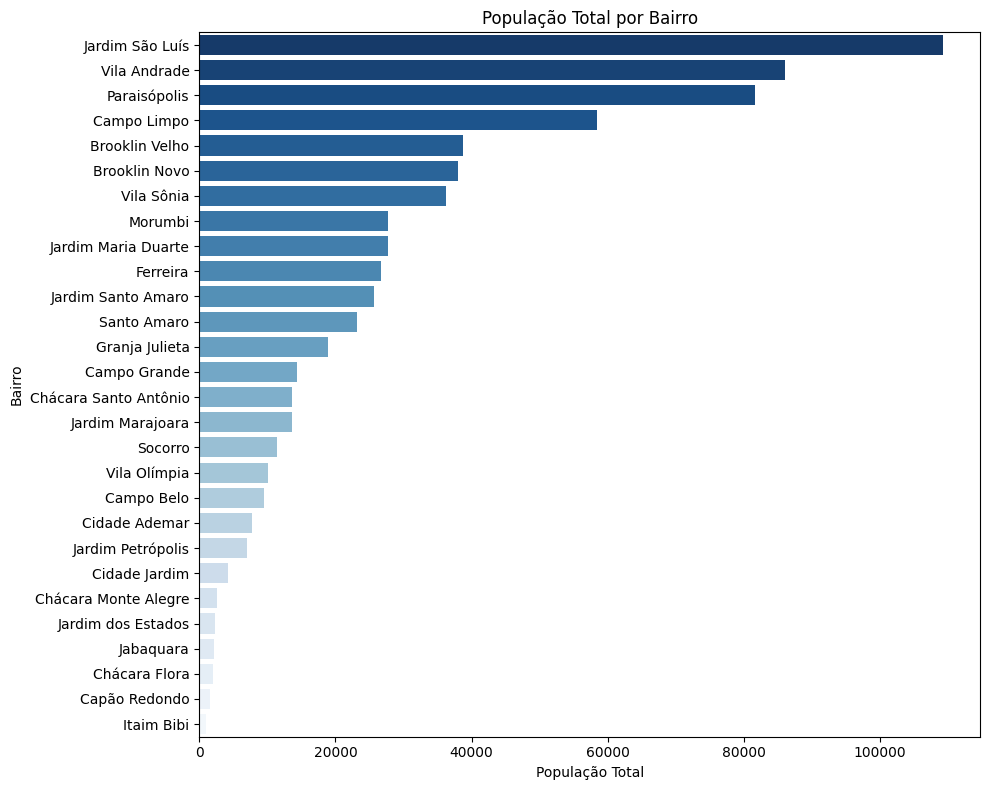


📊 População total por bairro:

01. Jardim São Luís: 109.194 habitantes
02. Vila Andrade: 86.046 habitantes
03. Paraisópolis: 81.632 habitantes
04. Campo Limpo: 58.367 habitantes
05. Brooklin Velho: 38.757 habitantes
06. Brooklin Novo: 38.028 habitantes
07. Vila Sônia: 36.276 habitantes
08. Morumbi: 27.767 habitantes
09. Jardim Maria Duarte: 27.671 habitantes
10. Ferreira: 26.722 habitantes
11. Jardim Santo Amaro: 25.648 habitantes
12. Santo Amaro: 23.097 habitantes
13. Granja Julieta: 18.870 habitantes
14. Campo Grande: 14.279 habitantes
15. Chácara Santo Antônio: 13.599 habitantes
16. Jardim Marajoara: 13.559 habitantes
17. Socorro: 11.442 habitantes
18. Vila Olímpia: 10.161 habitantes
19. Campo Belo: 9.444 habitantes
20. Cidade Ademar: 7.786 habitantes
21. Jardim Petrópolis: 7.018 habitantes
22. Cidade Jardim: 4.264 habitantes
23. Chácara Monte Alegre: 2.570 habitantes
24. Jardim dos Estados: 2.300 habitantes
25. Jabaquara: 2.199 habitantes
26. Chácara Flora: 2.024 habitantes
27. Ca

In [29]:
# Converter a coluna populacao_total para numérica
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce')

# Agrupar por bairro e somar a população
df_bairro = (
    df.groupby('Bairro', as_index=False)['populacao_total']
      .sum()
      .sort_values('populacao_total', ascending=False)
)

# Plotar gráfico (todos os bairros)
plt.figure(figsize=(10, 8))
sns.barplot(data=df_bairro, x='populacao_total', y='Bairro', palette='Blues_r')
plt.title('População Total por Bairro')
plt.xlabel('População Total')
plt.ylabel('Bairro')
plt.tight_layout()
plt.show()

# Exibir texto separado
print("\n📊 População total por bairro:\n")
for i, row in enumerate(df_bairro.itertuples(index=False), start=1):
    print(f"{i:02d}. {row.Bairro}: {int(row.populacao_total):,} habitantes".replace(',', '.'))

# Exibir total geral
total_pop = int(df_bairro['populacao_total'].sum())
print(f"\n👥 População total somada: {total_pop:,} habitantes".replace(',', '.'))


<div style=" background-color:#f9f9f9; border-left:6px solid #2b6cb0; padding:12px; color:#1a1a1a; font-size:15px; line-height:1.6; margin-top:10px; ">
<b>Observação:</b><br>
Observa-se que os bairros <b>Jardim São Luís</b> (109 mil habitantes), <b>Vila Andrade</b> (86 mil) e <b>Paraisópolis</b> (81 mil) concentram a maior parte da população local, representando áreas de forte densidade urbana.

<br> Regiões como <b>Morumbi</b> (27 mil habitantes) e <b>Jardim Santo Amaro</b> (25 mil) possuem densidade intermediária, enquanto bairros como <b>Chácara Monte Alegre</b> e <b>Itaim Bibi</b> têm menor concentração populacional. <br> A soma total das áreas analisadas chega a aproximadamente <b>701 mil habitantes</b>, evidenciando o potencial populacional da região e sua relevância para ações estratégicas da escola. </div>

# 5. Renda Média por Bairro (em Salários Mínimos) — Do Mais Rico ao Mais Pobre

C:\Users\00157NLUC-BrenoR\AppData\Local\Temp\ipykernel_13464\1284982327.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='renda_sm', y='Bairro', data=df_bairro, palette='viridis')


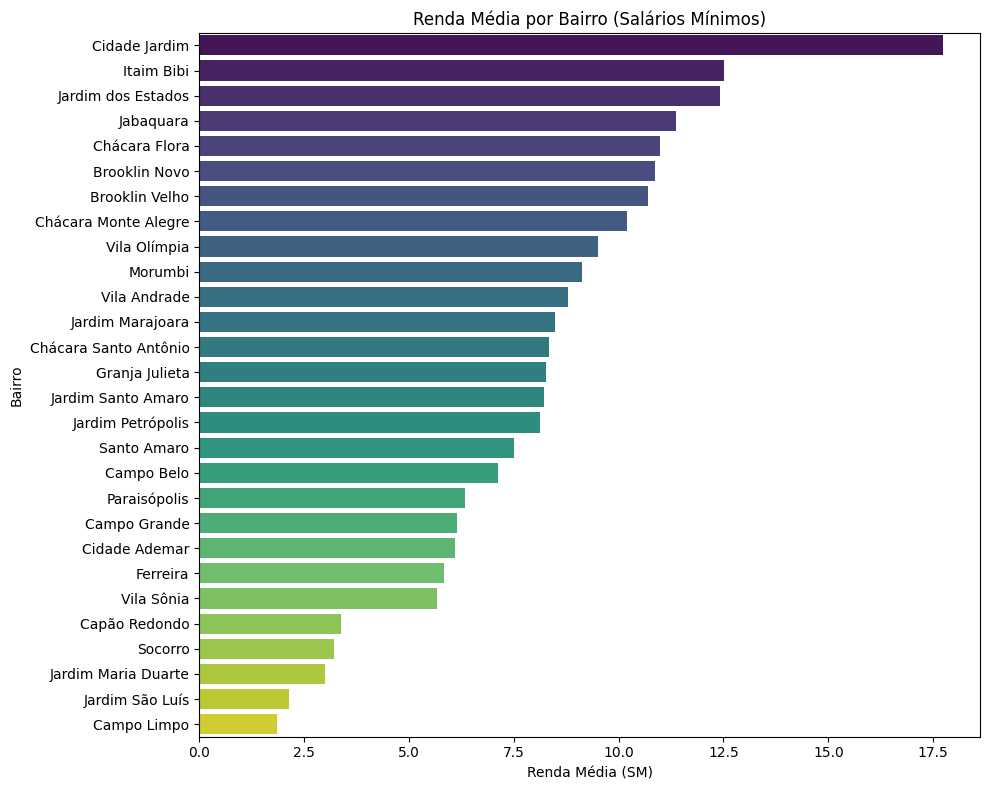


Renda Média por Bairro (em Salários Mínimos) - Do mais rico ao mais pobre:
               Bairro  renda_sm
        Cidade Jardim 17.730237
           Itaim Bibi 12.507719
   Jardim dos Estados 12.408584
            Jabaquara 11.378864
        Chácara Flora 10.985095
        Brooklin Novo 10.866483
       Brooklin Velho 10.688671
 Chácara Monte Alegre 10.201361
         Vila Olímpia  9.502683
              Morumbi  9.116121
         Vila Andrade  8.803410
     Jardim Marajoara  8.475592
Chácara Santo Antônio  8.337266
       Granja Julieta  8.266352
   Jardim Santo Amaro  8.227712
    Jardim Petrópolis  8.128848
          Santo Amaro  7.501155
           Campo Belo  7.123066
         Paraisópolis  6.324682
         Campo Grande  6.154685
        Cidade Ademar  6.091870
             Ferreira  5.841856
           Vila Sônia  5.674656
        Capão Redondo  3.371832
              Socorro  3.219584
  Jardim Maria Duarte  3.008902
      Jardim São Luís  2.132519
          Campo Limpo  1.843

In [30]:
# Carregar o CSV com as variáveis demográficas
df = pd.read_csv('Elvira - Chacara - INEP 35107700 Dados ADS_coords_corrigidas_com_enderecos.csv')

# Converter renda_media: substituir vírgula por ponto
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

# Calcular renda em salários mínimos
salario_minimo = 1380.0
df['renda_sm'] = df['renda_media'] / salario_minimo

# Agrupar por bairro e calcular a renda média em SM
df_bairro = df.groupby('Bairro')[['renda_sm']].mean().reset_index()
df_bairro = df_bairro.sort_values('renda_sm', ascending=False)

# Plotando a renda média (SM) por bairro - gráfico horizontal (ordem decrescente)
plt.figure(figsize=(10, 8))
sns.barplot(x='renda_sm', y='Bairro', data=df_bairro, palette='viridis')
plt.title('Renda Média por Bairro (Salários Mínimos)')
plt.xlabel('Renda Média (SM)')
plt.ylabel('Bairro')
plt.tight_layout()
plt.show()

# Estatísticas por bairro
print("\nRenda Média por Bairro (em Salários Mínimos) - Do mais rico ao mais pobre:")
print(df_bairro.to_string(index=False))

<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O gráfico apresenta a <b>renda média por bairro</b>, expressa em salários mínimos e ordenada do maior para o menor valor. 
A análise evidencia um cenário de <b>forte contraste socioeconômico</b> entre as regiões, refletindo a diversidade urbana característica da zona sul de São Paulo.
<br><br>
Os bairros com <b>maior poder aquisitivo</b> são <b>Cidade Jardim</b> (≈ 17,73 SM) e <b>Itaim Bibi</b> (≈ 12,50 SM), seguidos de <b>Jardim dos Estados</b> (≈ 12,40 SM) 
e <b>Chácara Flora</b> (≈ 10,98 SM). Esses locais concentram imóveis de alto padrão e infraestrutura consolidada, compondo o topo da distribuição de renda.
<br><br>
Em posição intermediária, com rendas entre 8 e 9 SM, estão <b>Morumbi</b>, <b>Vila Andrade</b>, <b>Chácara Santo Antônio</b> e <b>Granja Julieta</b>, 
bairros que apresentam perfis de classe média alta e residências de padrão misto.
<br><br>
Na base da distribuição aparecem <b>Jardim São Luís</b> (≈ 2,13 SM), <b>Campo Limpo</b> (≈ 1,84 SM) e <b>Capão Redondo</b> (≈ 3,38 SM), 
regiões com menor renda média e grande densidade populacional.
<br><br>
O conjunto dos dados reforça a presença de um <b>entorno heterogêneo</b>, onde áreas de alto padrão convivem próximas a zonas de menor poder econômico, 
evidenciando um mosaico urbano diverso e socialmente desigual.

</div>

# 6. Clustering de Áreas por Renda Média e População Total

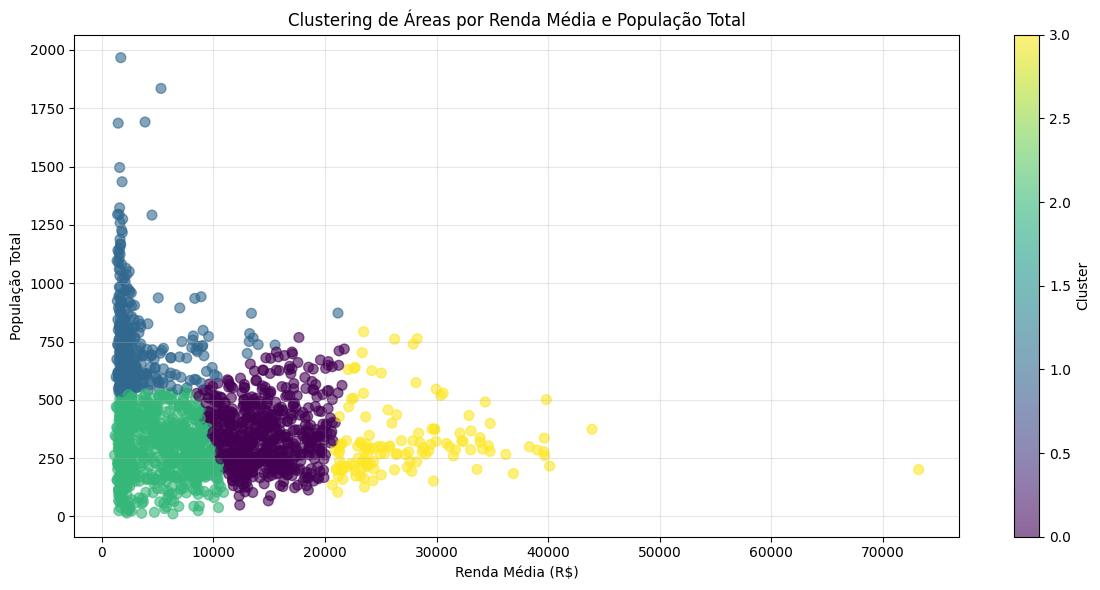


Estatísticas dos Clusters:

Cluster 0:
  Quantidade de áreas: 570
  Renda média (min - max): R$ 8,524.95 - R$ 21,732.02
  Renda média (média): R$ 14,537.49
  População total (min - max): 49 - 767
  População total (média): 356

Cluster 1:
  Quantidade de áreas: 315
  Renda média (min - max): R$ 1,296.04 - R$ 21,168.40
  Renda média (média): R$ 3,356.47
  População total (min - max): 526 - 1,967
  População total (média): 758

Cluster 2:
  Quantidade de áreas: 731
  Renda média (min - max): R$ 1,154.58 - R$ 10,910.34
  Renda média (média): R$ 5,073.13
  População total (min - max): 11 - 539
  População total (média): 301

Cluster 3:
  Quantidade de áreas: 128
  Renda média (min - max): R$ 20,671.45 - R$ 73,198.95
  Renda média (média): R$ 27,424.60
  População total (min - max): 104 - 792
  População total (média): 324


In [31]:
# Converter renda_media: substituir vírgula por ponto
df['renda_media'] = df['renda_media'].astype(str).str.replace(',', '.', regex=False)
df['renda_media'] = pd.to_numeric(df['renda_media'], errors='coerce')

# Converter população_total para numérico
df['populacao_total'] = pd.to_numeric(df['populacao_total'], errors='coerce')

# Remover linhas com NaN em renda_media ou populacao_total
data = df[['renda_media', 'populacao_total']].dropna()

# Normalizar os dados (importante para K-means)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# K-means clustering com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

# Adicionar as labels ao DataFrame
df_filtered = df[['renda_media', 'populacao_total']].dropna().copy()
df_filtered['cluster'] = clusters

# Plotando os clusters
plt.figure(figsize=(12, 6))
scatter = plt.scatter(df_filtered['renda_media'], df_filtered['populacao_total'], 
                     c=df_filtered['cluster'], cmap='viridis', s=50, alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering de Áreas por Renda Média e População Total')
plt.xlabel('Renda Média (R$)')
plt.ylabel('População Total')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estatísticas dos clusters
print("\nEstatísticas dos Clusters:")
print("=" * 80)
for cluster_id in range(4):
    cluster_data = df_filtered[df_filtered['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Quantidade de áreas: {len(cluster_data)}")
    print(f"  Renda média (min - max): R$ {cluster_data['renda_media'].min():,.2f} - R$ {cluster_data['renda_media'].max():,.2f}")
    print(f"  Renda média (média): R$ {cluster_data['renda_media'].mean():,.2f}")
    print(f"  População total (min - max): {cluster_data['populacao_total'].min():,.0f} - {cluster_data['populacao_total'].max():,.0f}")
    print(f"  População total (média): {cluster_data['populacao_total'].mean():,.0f}")

In [34]:
# Cria uma Series com o mesmo índice de "data" e junta no df original
cluster_s = pd.Series(clusters, index=data.index, name='cluster')

# Anexa ao df preservando a ordem/linhas originais
df_final = df.join(cluster_s)

# Converter para inteiro (mantendo NaN onde não há cluster)
df_final['cluster'] = df_final['cluster'].astype('Int64')

# Salvar
df_final.to_csv('Elvira_Brandao_Chacara_clusters.csv', index=False)
print("✅ Novo arquivo salvo com sucesso: Elvira_Brandao_Chacara_clusters.csv")


✅ Novo arquivo salvo com sucesso: Elvira_Brandao_Chacara_clusters.csv


<div style="
background-color:#f9f9f9;
border-left:6px solid #2b6cb0;
padding:12px;
color:#1a1a1a;
font-size:15px;
line-height:1.6;
margin-top:10px;
">

<b>Observação:</b><br>
O gráfico apresenta o resultado da aplicação do algoritmo <b>K-means</b> sobre as variáveis <i>renda média</i> e <i>população total</i> das áreas analisadas. 
O objetivo foi agrupar regiões com <b>características socioeconômicas semelhantes</b>, facilitando a identificação de padrões que auxiliem nas estratégias de captação.
<br><br>
Após a normalização dos dados, foram definidos <b>4 clusters</b>, representados por cores distintas no gráfico de dispersão. 
Cada ponto indica uma área (CEP) posicionada conforme sua renda média (eixo X) e população total (eixo Y).
<br><br>
As principais características de cada grupo são:
<ul>
<li><b>Cluster 0</b> — Abrange 570 áreas com <b>renda média</b> entre R$ 8.524,95 e R$ 21.732,02 (média de R$ 14.537,49) e <b>população</b> variando de 49 a 767 habitantes (média de 356). Representa zonas de <b>renda média a alta</b> e densidade moderada.</li>
<li><b>Cluster 1</b> — Composto por 315 áreas, possui <b>renda média</b> entre R$ 1.296,04 e R$ 21.168,40 (média de R$ 3.356,47) e <b>população</b> entre 526 e 1.967 habitantes (média de 758). Reflete regiões de <b>baixa renda e alta densidade populacional</b>.</li>
<li><b>Cluster 2</b> — Inclui 731 áreas, com <b>renda média</b> entre R$ 1.154,58 e R$ 10.910,34 (média de R$ 5.073,13) e <b>população</b> de 11 a 539 habitantes (média de 301). Corresponde a áreas de <b>renda intermediária</b> e baixa densidade.</li>
<li><b>Cluster 3</b> — Reúne 128 áreas com <b>renda média</b> de R$ 20.671,45 a R$ 73.198,95 (média de R$ 27.424,60) e <b>população</b> entre 104 e 792 habitantes (média de 324). Representa <b>regiões de alta renda e população moderada</b>.</li>
</ul>
<br>
A distribuição visual dos clusters revela a <b>heterogeneidade socioeconômica</b> das áreas estudadas, destacando a coexistência de regiões de alto padrão próximas a zonas mais populosas e de menor renda. 
Essa segmentação é fundamental para <b>compreender os diferentes perfis de público e planejar estratégias de captação mais direcionadas</b> conforme o poder aquisitivo e a densidade de cada grupo.

</div>
